# SSH and DSW export changes

In [1]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

#figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'
figdir = '/g/data/v45/akm157/figures/easterlies/paper_figures/'

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34913/status,
Dashboard: /proxy/34913/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42647,Workers: 7
Dashboard: /proxy/34913/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:43661,Total threads: 4
Dashboard: /proxy/34707/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:36199,


Load datasets

In [2]:
session = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
#session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'

ti = '2150-01-01'
tf = '2160-06-30'

In [3]:
ht = cc.querying.getvar(experiment_ryf, 'ht', session, n = 1).sel(yt_ocean = slice(None, -58))

### Sea level

In [4]:
slev = {}
slev['ctrl'] = cc.querying.getvar(experiment_ryf, 'sea_level', session,frequency='1 monthly', start_time = '2149-07-01', end_time = tf).sel(time = slice('2149-07-01', tf), yt_ocean = slice(None, -58))
slev['up'] = cc.querying.getvar(experiment_eup, 'sea_level', session,frequency='1 monthly', start_time = ti, end_time = tf).sel(time = slice(ti, tf), yt_ocean = slice(None, -58))
slev['down'] = cc.querying.getvar(experiment_edo, 'sea_level', session,frequency='1 monthly', start_time = ti, end_time = tf).sel(time = slice(ti, tf),yt_ocean = slice(None, -58))

Append 6 months of control to up and down

In [5]:
slev['up'] = xr.concat([slev['ctrl'].isel(time = slice(None, 6)), slev['up']], dim = 'time')
slev['down'] = xr.concat([slev['ctrl'].isel(time = slice(None, 6)), slev['down']], dim = 'time')

In [6]:
lat_slice = slice(-80,-58)
lon_slice = slice(-280, 80)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [7]:
slev_mask = {}
for k in ['ctrl', 'up', 'down']:
    slev_mask[k], shelf_mask = shelf_mask_isobath(slev[k])

In [8]:
# Area for weighting
area_t = cc.querying.getvar(experiment_ryf, 'area_t', session, ncfile = 'ocean_grid.nc', n = -1)
area_t = area_t.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [9]:
slev_clim_control = ((slev_mask['ctrl']*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month').mean('time')
slev_anom_mask = {}
for k in ['up', 'down']:
    slev_anom_mask[k] = ((slev_mask[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month') - slev_clim_control

### DSW export

In [10]:
nfiles = 126
path_ctrl = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/*'))[:nfiles]

vol_transp_ctrl = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_ctrl)):
    vol_transp_ctrl = xr.concat([vol_transp_ctrl, xr.open_dataset(path_ctrl[i])], dim = 'time')
    
vol_transp_ctrl['time'] = slev_anom_mask['up'].isel(time = slice(6, None))['time'].values[:nfiles]
vol_transp_ctrl_total = (vol_transp_ctrl['vol_trans_across_contour_binned']*vol_transp_ctrl['ndays']).sum('time')/np.sum(vol_transp_ctrl['ndays'])

In [11]:
path_up = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/*'))[:nfiles]

vol_transp_up = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up)):
    vol_transp_up = xr.concat([vol_transp_up, xr.open_dataset(path_up[i])], dim = 'time')
    
vol_transp_up['time'] = slev_anom_mask['up'].isel(time = slice(6, None))['time'].values[:nfiles]
vol_transp_up_total = (vol_transp_up['vol_trans_across_contour_binned']*vol_transp_up['ndays']).sum('time')/np.sum(vol_transp_up['ndays'])

In [12]:
path_down = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/*'))[:nfiles]

vol_transp_do = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')
for i in range(1, len(path_down)):
    vol_transp_do = xr.concat([vol_transp_do, xr.open_dataset(path_down[i])], dim = 'time')
    
vol_transp_do['time'] = slev_anom_mask['up'].isel(time = slice(6, None))['time'].values[:nfiles]
vol_transp_do_total = (vol_transp_do['vol_trans_across_contour_binned']*vol_transp_do['ndays']).sum('time')/np.sum(vol_transp_do['ndays'])

In [13]:
vol_transp_ct_tv = vol_transp_ctrl['vol_trans_across_contour_binned']
vol_transp_up_tv = vol_transp_up['vol_trans_across_contour_binned']
vol_transp_do_tv = vol_transp_do['vol_trans_across_contour_binned']

trans_sum_ct_tv = vol_transp_ct_tv.sum('contour_index')
trans_sum_up_tv = vol_transp_up_tv.sum('contour_index')
trans_sum_do_tv = vol_transp_do_tv.sum('contour_index')

psi_ct_tv = trans_sum_ct_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_up_tv = trans_sum_up_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_do_tv = trans_sum_do_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]

In [14]:
DSW_export_ct = np.empty(len(psi_ct_tv['time']))
DSW_export_up = np.empty(len(psi_up_tv['time']))
DSW_export_do = np.empty(len(psi_do_tv['time']))

# find max DSW density:
DSW_top_density_ct = psi_ct_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_up = psi_up_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_do = psi_do_tv.argmax('isopycnal_bins')

n = 0
for t in psi_up_tv['time']:
    
    # sum over DSW layer:
    DSW_trans_ct = psi_ct_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_ct.sel(time = t)))
    DSW_export_ct[n] = DSW_trans_ct.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_up = psi_up_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_up.sel(time = t)))
    DSW_export_up[n] = DSW_trans_up.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_do = psi_do_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_do.sel(time = t)))
    DSW_export_do[n] = DSW_trans_do.item()/1e6
    n += 1

In [15]:
DSW_export_ct = xr.DataArray(DSW_export_ct, dims = ['time'], coords = {'time':slev_anom_mask['up'].isel(time = slice(6, None))['time']})
DSW_export_up = xr.DataArray(DSW_export_up, dims = ['time'], coords = {'time':slev_anom_mask['up'].isel(time = slice(6, None))['time']})
DSW_export_do = xr.DataArray(DSW_export_do, dims = ['time'], coords = {'time':slev_anom_mask['up'].isel(time = slice(6, None))['time']})

Append climatology of control to the beginning of each experiment

In [16]:
DSW_clim = DSW_export_ct.groupby('time.month').mean('time')
DSW_clim = DSW_clim.rename({'month':'time'})
DSW_clim = DSW_clim[6:]
DSW_clim['time'] = slev_anom_mask['up']['time'][0:6].values

DSW_export_ct = xr.concat([DSW_clim, DSW_export_ct], dim = 'time')
DSW_export_up = xr.concat([DSW_clim, DSW_export_up], dim = 'time')
DSW_export_do = xr.concat([DSW_clim, DSW_export_do], dim = 'time')

With rolling mean

## Plot

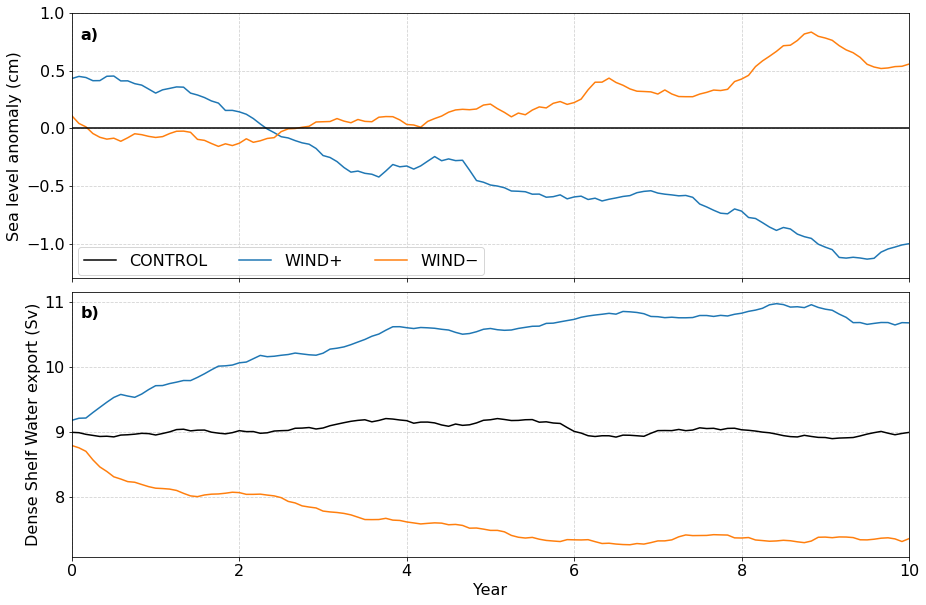

In [21]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

for ax, lb in zip(axs, ['a)', 'b)']):
    ax.text(0.01, 0.9, lb, transform = ax.transAxes, weight = 'bold')
    
for k in ['up', 'down']:
    axs[0].plot(np.arange(0, 126, 1), slev_anom_mask[k].rolling(time = 12, center = True).mean('time').isel(time=slice(6,None))*100)
axs[0].plot(np.arange(0, 126, 1), 0*slev_anom_mask[k].rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 'k')
axs[1].plot(np.arange(0, 126, 1), DSW_export_ct.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), color = 'k', label = 'CONTROL')
axs[1].plot(np.arange(0, 126, 1), DSW_export_up.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), color = 'C0', label = 'WIND+')
axs[1].plot(np.arange(0, 126, 1), DSW_export_do.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), color = 'C1', label = 'WIND$-$')

axs[1].legend(ncol = 3, loc = 'upper center', bbox_to_anchor = (0.25,1.2))

axs[0].set_xlim(0,120)
axs[0].set_ylim(-1.3,1)
axs[1].set_xlim(0,120)
axs[0].set_xticks(np.arange(0, 144, 24))
axs[1].set_xticks(np.arange(0, 144, 24))
axs[1].set_xticklabels(np.arange(0, 12, 2))
axs[0].set_xticklabels([])
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomaly (cm)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Dense Shelf Water export (Sv)')

plt.tick_params(labelsize=16)

plt.savefig(figdir+'Figure-2.pdf', bbox_inches = 'tight')